In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.decomposition import PCA
from IPython import display
import matplotlib.cm as cm
from matplotlib.pyplot import savefig
%matplotlib inline

### Visualizing the dataset

In [2]:
df = pd.read_csv('shealth.csv', sep=';')
df = df.set_index('Date')
df.head()

,Day,Weigth,Steps,Walk (min),Swimming (min),other sports (min),Spent kcal,GPS country
Date,,,,,,,,
20/05/2015,W,"68,4",6620.0,75,0,6,380,33
21/05/2015,Th,"68,3",8111.0,70,0,11,452,33
22/05/2015,F,"68,7",9283.0,85,40,0,686,33
23/05/2015,Sa,"68,6",5995.0,53,0,0,237,33
24/05/2015,Su,"68,4",1419.0,12,0,0,71,33


In [3]:
df.fillna(np.mean(df.Steps), inplace=True)
df['Weigth'] = df.Weigth.apply(lambda s: s.replace(',', '.')).astype(float)
df.head()

,Day,Weigth,Steps,Walk (min),Swimming (min),other sports (min),Spent kcal,GPS country
Date,,,,,,,,
20/05/2015,W,68.4,6620.0,75,0,6,380,33
21/05/2015,Th,68.3,8111.0,70,0,11,452,33
22/05/2015,F,68.7,9283.0,85,40,0,686,33
23/05/2015,Sa,68.6,5995.0,53,0,0,237,33
24/05/2015,Su,68.4,1419.0,12,0,0,71,33


In [4]:
# classic one hot encoding
X_ohe = pd.concat([df.drop(['Day'], axis=1), pd.get_dummies(df['Day'])], axis=1)
X_ohe.head()

,Weigth,Steps,Walk (min),Swimming (min),other sports (min),Spent kcal,GPS country,F,M,Sa,Su,Th,Tu,W
Date,,,,,,,,,,,,,,
20/05/2015,68.4,6620.0,75,0,6,380,33,0,0,0,0,0,0,1
21/05/2015,68.3,8111.0,70,0,11,452,33,0,0,0,0,1,0,0
22/05/2015,68.7,9283.0,85,40,0,686,33,1,0,0,0,0,0,0
23/05/2015,68.6,5995.0,53,0,0,237,33,0,0,1,0,0,0,0
24/05/2015,68.4,1419.0,12,0,0,71,33,0,0,0,1,0,0,0


In [5]:
# weekend encoding
X_weekend = df
X_weekend['Day'] = ((df['Day']=='Su') | (df['Day'] == 'Sa')).astype(int)
X_weekend.head()

,Day,Weigth,Steps,Walk (min),Swimming (min),other sports (min),Spent kcal,GPS country
Date,,,,,,,,
20/05/2015,0,68.4,6620.0,75,0,6,380,33
21/05/2015,0,68.3,8111.0,70,0,11,452,33
22/05/2015,0,68.7,9283.0,85,40,0,686,33
23/05/2015,1,68.6,5995.0,53,0,0,237,33
24/05/2015,1,68.4,1419.0,12,0,0,71,33


### Parser function for the dataset

In [6]:
def parse_dataset(df, enc='weekend'):
    """
    ohe: normal one hot enconding for the 'Day' variable
    weekend: 1 if 'Day' is Sunday or Saturday, 0 otherwise
    """

    if enc not in ['ohe', 'weekend']:
        print("enc parameter should be either 'ohe' or 'weekend'")

    df = pd.read_csv('shealth.csv', sep=';')
    df = df.set_index('Date')

    df = df.fillna(np.mean(df.Steps))
    df['Weigth'] = df.Weigth.apply(lambda s: s.replace(',', '.')).astype(float)

    if enc == 'ohe':
        X = pd.concat([df.drop(['Day'], axis=1),
                       pd.get_dummies(df['Day'])], axis=1)
    else:
        X = df
        X['Day'] = ((df['Day'] == 'Su') | (df['Day'] == 'Sa')).astype(int)
    return X

### KMeans algorithm

In [7]:
def KMeans(X, K, maxIters=10):
    """"
    X: data, numpy array
    K: number of cluster, integer
    maxIters: number maximum of iterations, integer
    """
    centroids = X[np.random.choice(np.arange(len(X)), K), :]
    for i in range(maxIters):
        # Cluster Assignment step
        C = np.array([np.argmin([np.dot(x_i - y_k, x_i - y_k)
                                 for y_k in centroids]) for x_i in X])
        # Move centroids step
        centroids = [X[C == k].mean(axis=0) for k in range(K)]
    return np.array(centroids), C

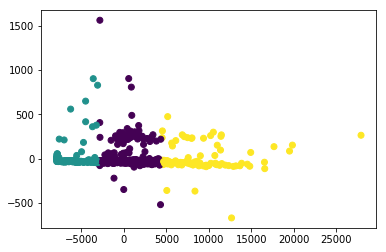

In [8]:
# test KMeans algorithm
X = parse_dataset(df, enc='weekend').values

centroids, C = KMeans(X, 3, 100)

pca = PCA(2)
X_pca = pca.fit_transform(X)
X_pca.shape

plt.scatter(X_pca[:,0], X_pca[:, 1], c=C)

### Online KMeans algorithm

In [40]:
class OnlineKMeans:

    def __init__(self, X, K=2, window_size=np.inf, plot_progress=False, add_remove=False,
                 threshold_create=np.inf, threshold_remove=np.inf, cold_start=False):
        self.X = X
        self.K = K
        self.window_size = window_size
        self.plot_progress = plot_progress
        self._nsamples = X.shape[0]
        self._dim = X.shape[1]
        self._eps = 1e-3
        self.threshold_create = threshold_create
        self.threshold_remove = threshold_remove
        self.add_remove = add_remove
        self.cold_start = cold_start
        plt.figure(figsize=(15, 4))

        if self._nsamples < K:
            print("Error")

    def _plot_progress(self, c, centroids):
        pca = PCA(2)
        pca.fit(self._X_norm)
        X_pca = pca.transform(self._X_norm)

        centroids_ = [centroids[i]
                      for i in range(len(centroids)) if i not in self._infidx]
        centroids_pca = pca.transform(centroids_)

        plt.clf()

        plt.subplot(121)
        plt.title('Online clustering progress')

        colors = cm.rainbow([0.2 * i for i in range(self.K)]).tolist()
        map_colors = [colors[k] for k in c]
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=map_colors)
        plt.scatter(centroids_pca[:, 0],
                    centroids_pca[:, 1], color='black', marker='x')

        plt.subplot(122)
        plt.title('Average distance from the centroid')
        plt.ylim(ymax=12)

        max_dim = np.max([len(self._mean_dist[i])
                          for i in range(len(self._mean_dist))])

        for i in range(len(self._mean_dist)):
            self._mean_dist[i].extend(
                [0] * (max_dim - len(self._mean_dist[i])))

        for k in range(self.K):
            plt.plot(np.array(self._mean_dist)[
                     :, k], color=colors[k], label='cluster ' + str(k))

        plt.legend()

        display.display(plt.gcf())
        display.clear_output(wait=True)
        plt.savefig('imagen.pdf')

    def data_stream(self):
        """
        Simulate data streaming
        """
        yield from self.X

    def distance(self, x, y, method='euclidean'):
        if method is 'euclidean':
            return np.sqrt(np.dot(x - y, x - y))
        else:
            print('%s distance unknown' % method)

    def update_centroids(self, gamma, data_point, centroid):
        return (centroid + gamma * (data_point - centroid))

    def add_cluster(self):
        self.K += 1

    def run(self, max_iter=100):
        
        stream = self.data_stream()
        C = list(range(self.K))
        
        if self.cold_start:
            centroids = np.random.multivariate_normal(np.zeros(self._dim), np.eye(self._dim), self.K)            
            init = 0
            
        else:
            centroids = np.array([next(stream) for _ in range(self.K)])
            init = self.K
        
        
        # To normalize data on the fly
        mean = np.mean(centroids, axis=0)
        sigma = np.std(centroids, axis=0)
        centroids = (centroids - mean) / (sigma + self._eps)

        # auxiliary vectors only for plotting purposes
        self._X_norm = list(centroids)
        self._mean_dist = [[0] * self.K]
        self._infidx = []

        for t in range(init, min(self._nsamples, max_iter)):
            p = next(stream)

            mean_new = (t * mean + p) / (t + 1)
            sigma_new = np.sqrt(
                (sigma**2 * t + (p - mean) * (p - mean_new)) / (t + 1))

            normalized_p = (p - mean_new) / (sigma_new + self._eps)
            centroids = (centroids * sigma + mean - mean_new) / (sigma_new + self._eps)

            if self.add_remove:
                idx = np.argmin([self.distance(normalized_p, c)
                                 for c in centroids])

                # Condition to add a new cluster
                if self.distance(normalized_p, centroids[idx]) > self.threshold_create:
                    C.append(self.K)
                    self.add_cluster()
                    centroids = np.append(centroids, [normalized_p], axis=0)

                # Condition to remove cluster
                else:
                    while t - np.max(np.where(C == idx)) > self.threshold_remove:
                        centroids[idx] = np.inf * np.ones(self._dim)
                        self._infidx.append(idx)
                        idx = np.argmin([self.distance(normalized_p, c)
                                         for c in centroids])

                    C.append(
                        np.argmin([self.distance(normalized_p, c) for c in centroids]))

                    if self.window_size < t:
                        centroids[C[-1]] = self.update_centroids(1 / self.window_size,
                                                                 normalized_p, centroids[C[-1]])

                    else:
                        centroids[C[-1]] = self.update_centroids(1 / (t+1),
                                                                 normalized_p, centroids[C[-1]])

            else:
                C.append(
                    np.argmin([self.distance(normalized_p, c) for c in centroids]))

                if self.window_size < t:
                    centroids[C[-1]] = self.update_centroids(1 / self.window_size,
                                                             normalized_p, centroids[C[-1]])
                else:
                    centroids[C[-1]] = self.update_centroids(1 / (t+1),
                                                             normalized_p, centroids[C[-1]])

            # Update mean and sigma
            mean = mean_new
            sigma = sigma_new
                    
            # We save the normalized points and mean distance only for plotting purposes
            self._X_norm.append(normalized_p)
            self._mean_dist.append([np.mean([self.distance(
                p, centroids[k]) for p in self._X_norm[C == k]], axis=0) for k in range(self.K)])

            if self.plot_progress:
                self._plot_progress(C, centroids)

        return np.array(centroids), C

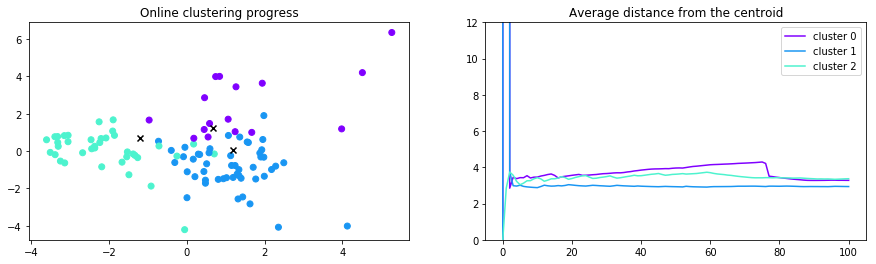

In [44]:
X = parse_dataset(df, enc='weekend').values

online_kmeans = OnlineKMeans(X, K=3, plot_progress=True,
                             add_remove=True, cold_start=True)
centroids, c = online_kmeans.run(max_iter=100)

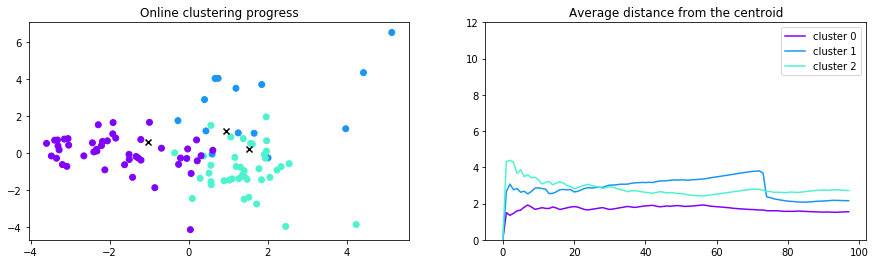

In [37]:
online_kmeans = OnlineKMeans(X, K=3, plot_progress=True,
                             add_remove=True)
centroids, c = online_kmeans.run(max_iter=100)

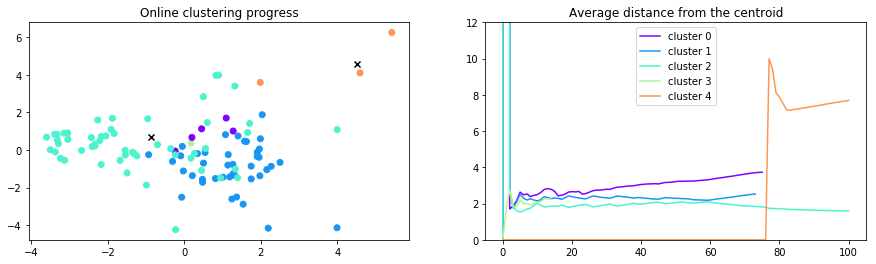

In [42]:
X = parse_dataset(df, enc='weekend').values

online_kmeans = OnlineKMeans(X, K=3, plot_progress=True,
                             add_remove=True, threshold_create=7, threshold_remove=10, cold_start=True)
centroids, c = online_kmeans.run(max_iter=100)

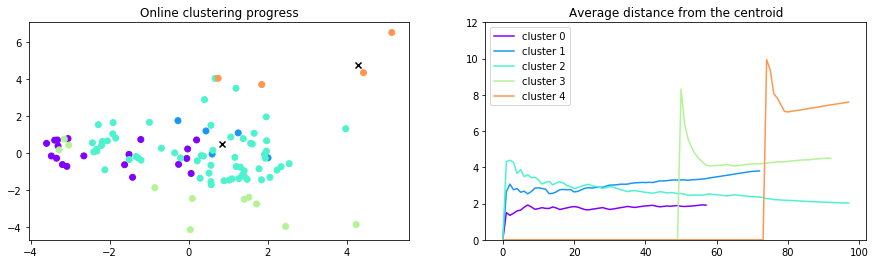

In [43]:
X = parse_dataset(df, enc='weekend').values

online_kmeans = OnlineKMeans(X, K=3, plot_progress=True,
                             add_remove=True, threshold_create=7, threshold_remove=10, cold_start=False)
centroids, c = online_kmeans.run(max_iter=100)